In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from codecarbon import track_emissions

In [2]:
# Configurações iniciais
TASK = "Infection"  # "Infection" ou "Ischaemia"
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
MODEL_NAME = "resnet50"  # "efficientnet" ou "resnet50"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Pré-processamento de Imagens
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
root_dir = "../data/infection"


# 2. Dataset Customizado
class DFUDataset(Dataset):
    def __init__(self, root_dir, task=TASK, transform=None):
        self.root_dir = root_dir
        self.task = task

        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.identifiers = []  # Novo campo para identificadores únicos

        # Validate that root_dir is a valid path
        if not isinstance(root_dir, str):
            raise TypeError(f"Expected root_dir to be a string, but got {type(root_dir).__name__}")

        print("TASK: " + TASK)

        positive_dir = os.path.join(root_dir, "Aug-Positive")
        negative_dir = os.path.join(root_dir, "Aug-Negative")


        # Carregar imagens positivas
        for img_name in os.listdir(positive_dir):
            self.image_paths.append(os.path.join(positive_dir, img_name))
            self.labels.append(1)
            # Extrair identificador único (ex: "imagem" de "imagem_1X_M.jpg")
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

        # Carregar imagens negativas
        for img_name in os.listdir(negative_dir):
            self.image_paths.append(os.path.join(negative_dir, img_name))
            self.labels.append(0)
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# 3. Modelo com Regularização
def create_model():
    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1  # Ou ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
    elif MODEL_NAME == "efficientnet":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Ou EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 1)
        )
    return model.to(DEVICE)

In [6]:
# 6. Cálculo de Métricas
def calculate_metrics(true, preds):
    preds_class = (preds > 0.5).astype(int)
    return {
        'auc': roc_auc_score(true, preds),
        'pr_auc': average_precision_score(true, preds),
        'f1': f1_score(true, preds_class),
        'accuracy': accuracy_score(true, preds_class),
        'precision': precision_score(true, preds_class),
        'recall': recall_score(true, preds_class),
        'confusion_matrix': confusion_matrix(true, preds_class)
    }

In [7]:
# 5. Função de Avaliação
@track_emissions(output_dir="../reports/emissions", output_file="infection_resnet50.csv") 
def evaluate_model(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return np.mean(losses), metrics

In [8]:
# 4. Função de Treinamento com Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, fold):
    best_loss = float('inf')
    patience_counter = 0
    patience = 3

    history = {
        'train_loss': [],
        'val_loss': [],
        'auc': [],
        'f1': []
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validação
        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)
        epoch_loss = running_loss / len(train_loader.dataset)

        # Registrar métricas
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['auc'].append(val_metrics['auc'])
        history['f1'].append(val_metrics['f1'])

        print(f'Fold {fold}, Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Val AUC: {val_metrics["auc"]:.4f}, F1: {val_metrics["f1"]:.4f}')

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    import os
    output_dir = "../models/infection"
    os.makedirs(output_dir, exist_ok=True)
    # Salva o modelo final do fold
    last_path = os.path.join(output_dir, f"last_model_fold{fold}.pth")
    torch.save(model.state_dict(), last_path)

    return history

In [9]:
# 7. Grad-CAM
def generate_grad_cam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_tensor.permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)
    return visualization

In [10]:
def plot_training_histories(histories):
    plt.figure(figsize=(15, 10))

    # Cores para diferentes folds
    colors = ['b', 'g', 'r', 'c', 'm']

    # Plot Loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['train_loss'])+1)
        plt.plot(epochs, history['train_loss'], linestyle='--', color=colors[i], label=f'Fold {i+1} Train')
        plt.plot(epochs, history['val_loss'], linestyle='-', color=colors[i], label=f'Fold {i+1} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot AUC
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['auc'])+1)
        plt.plot(epochs, history['auc'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot F1-Score
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['f1'])+1)
        plt.plot(epochs, history['f1'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig('training_histories.png')
    plt.show()

In [11]:
# 8. Validação Cruzada
@track_emissions(output_dir="../reports/emissions", output_file="infection_resnet50_cv.csv") 
def cross_validation():

    dataset = DFUDataset("../data/infection", transform=transform)
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  # Alterado para StratifiedGroupKFold

    all_metrics = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(
        X=np.zeros(len(dataset.labels)),  # Dummy data
        y=dataset.labels,
        groups=dataset.identifiers  # Grupos dos identificadores
    )):
        print(f'\nFold {fold+1}/5')

        # Split adicional: 80% treino, 20% teste interno
        train_idx, test_idx = train_test_split(
            train_idx,
            test_size=0.2,
            stratify=np.array(dataset.labels)[train_idx],
            random_state=42
        )

        # Split datasets
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_subsampler)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Inicialização
        model = create_model()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # L2 regularization

        history = train_model(model, train_loader, val_loader, criterion, optimizer, fold+1)
        fold_histories.append(history)

        plot_training_histories(fold_histories)

        # Avaliação no conjunto de teste interno
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, test_metrics = evaluate_model(model, test_loader, criterion)

        # Carregar melhor modelo e avaliar
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, metrics = evaluate_model(model, val_loader, criterion)

         # Adicione as métricas de teste
        all_metrics.append({
            'fold': fold+1,
            'val_metrics': metrics,
            'test_metrics': test_metrics
        })

    pd.DataFrame(fold_histories).to_csv('../reports/metrics/training_history_infection_resnet50.csv', index=False)


    # Processar all_metrics para formato tabular
    metrics_rows = []
    for m in all_metrics:
        row = {
            'fold': m['fold'],
            **{f'val_{k}': v for k, v in m['val_metrics'].items()},
            **{f'test_{k}': v for k, v in m['test_metrics'].items()}
        }
        metrics_rows.append(row)

    pd.DataFrame(metrics_rows).to_csv('../reports/metrics/fold_metrics_infection_resnet50.csv', index=False)

    # Relatório Final
    print("\nResultados da Validação Cruzada:")

    # Para métricas de validação
    print("\n--- Métricas de Validação ---")
    for key in all_metrics[0]['val_metrics']:
        if key != 'confusion_matrix':
            mean_val = np.mean([m['val_metrics'][key] for m in all_metrics])
            std_val = np.std([m['val_metrics'][key] for m in all_metrics])
            print(f'Val_{key.upper()}: {mean_val:.4f} ± {std_val:.4f}')

    # Para métricas de teste interno
    print("\n--- Métricas de Teste Interno ---")
    for key in all_metrics[0]['test_metrics']:
        if key != 'confusion_matrix':
            mean_test = np.mean([m['test_metrics'][key] for m in all_metrics])
            std_test = np.std([m['test_metrics'][key] for m in all_metrics])
            print(f'Test_{key.upper()}: {mean_test:.4f} ± {std_test:.4f}')

    return fold_histories, all_metrics

[codecarbon WARNING @ 20:19:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:19:03] [setup] RAM Tracking...
[codecarbon INFO @ 20:19:03] [setup] CPU Tracking...
[codecarbon WARNING @ 20:19:05] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 20:19:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:19:05] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 20:19:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:19:05] [setup] GPU Tracking...
[codecarbon INFO @ 20:19:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:19:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c

TASK: Infection

Fold 1/5


[codecarbon INFO @ 20:19:23] Energy consumed for RAM : 0.000159 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:19:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:19:23] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 20:19:23] Energy consumed for all GPUs : 0.000046 kWh. Total GPU Power : 10.918277341565512 W
[codecarbon INFO @ 20:19:23] 0.000381 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:19:38] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:19:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:19:38] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 20:19:38] Energy consumed for all GPUs : 0.000087 kWh. Total GPU Power : 10.023349909844633 W
[codecarbon INFO @ 20:19:38] 0.000758 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:

Fold 1, Epoch 1/100
Train Loss: 0.3830 | Val Loss: 0.5076
Val AUC: 0.8443, F1: 0.7764


[codecarbon INFO @ 20:24:53] Energy consumed for RAM : 0.003641 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:24:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:24:53] Energy consumed for All CPU : 0.004073 kWh
[codecarbon INFO @ 20:24:53] Energy consumed for all GPUs : 0.000884 kWh. Total GPU Power : 11.863586509888215 W
[codecarbon INFO @ 20:24:53] 0.008598 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:25:08] Energy consumed for RAM : 0.003799 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:25:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:25:08] Energy consumed for All CPU : 0.004250 kWh
[codecarbon INFO @ 20:25:08] Energy consumed for all GPUs : 0.000934 kWh. Total GPU Power : 11.982238769459606 W
[codecarbon INFO @ 20:25:08] 0.008983 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:

Fold 1, Epoch 2/100
Train Loss: 0.2800 | Val Loss: 0.4851
Val AUC: 0.8519, F1: 0.7687


[codecarbon INFO @ 20:30:53] Energy consumed for RAM : 0.007440 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:30:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:30:53] Energy consumed for All CPU : 0.008324 kWh
[codecarbon INFO @ 20:30:53] Energy consumed for all GPUs : 0.002110 kWh. Total GPU Power : 11.993404966571013 W
[codecarbon INFO @ 20:30:53] 0.017873 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:31:08] Energy consumed for RAM : 0.007598 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:31:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:31:08] Energy consumed for All CPU : 0.008501 kWh
[codecarbon INFO @ 20:31:08] Energy consumed for all GPUs : 0.002161 kWh. Total GPU Power : 12.19492988082537 W
[codecarbon INFO @ 20:31:08] 0.018259 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:3

Fold 1, Epoch 3/100
Train Loss: 0.1874 | Val Loss: 0.5042
Val AUC: 0.8529, F1: 0.7758


[codecarbon INFO @ 20:37:09] Energy consumed for RAM : 0.011397 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:37:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:37:09] Energy consumed for All CPU : 0.012750 kWh
[codecarbon INFO @ 20:37:09] Energy consumed for all GPUs : 0.003368 kWh. Total GPU Power : 11.754573371835258 W
[codecarbon INFO @ 20:37:09] 0.027515 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:37:09] 0.002526 g.CO2eq/s mean an estimation of 79.65015627014697 kg.CO2eq/year
[codecarbon INFO @ 20:37:24] Energy consumed for RAM : 0.011555 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:37:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:37:24] Energy consumed for All CPU : 0.012927 kWh
[codecarbon INFO @ 20:37:24] Energy consumed for all GPUs : 0.003418 kWh. Total GPU Power : 11.966783166933794 W
[codecarbon INFO @ 20:37:24] 0.0

Fold 1, Epoch 4/100
Train Loss: 0.1015 | Val Loss: 0.5556
Val AUC: 0.8467, F1: 0.7695


[codecarbon INFO @ 20:44:09] Energy consumed for RAM : 0.015829 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:44:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:44:09] Energy consumed for All CPU : 0.017709 kWh
[codecarbon INFO @ 20:44:09] Energy consumed for all GPUs : 0.004762 kWh. Total GPU Power : 12.075614301725366 W
[codecarbon INFO @ 20:44:09] 0.038299 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:44:24] Energy consumed for RAM : 0.015987 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:44:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:44:24] Energy consumed for All CPU : 0.017886 kWh
[codecarbon INFO @ 20:44:24] Energy consumed for all GPUs : 0.004812 kWh. Total GPU Power : 12.005746766697708 W
[codecarbon INFO @ 20:44:24] 0.038684 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:

Fold 1, Epoch 5/100
Train Loss: 0.0483 | Val Loss: 0.6140
Val AUC: 0.8472, F1: 0.7860
Early stopping at epoch 5


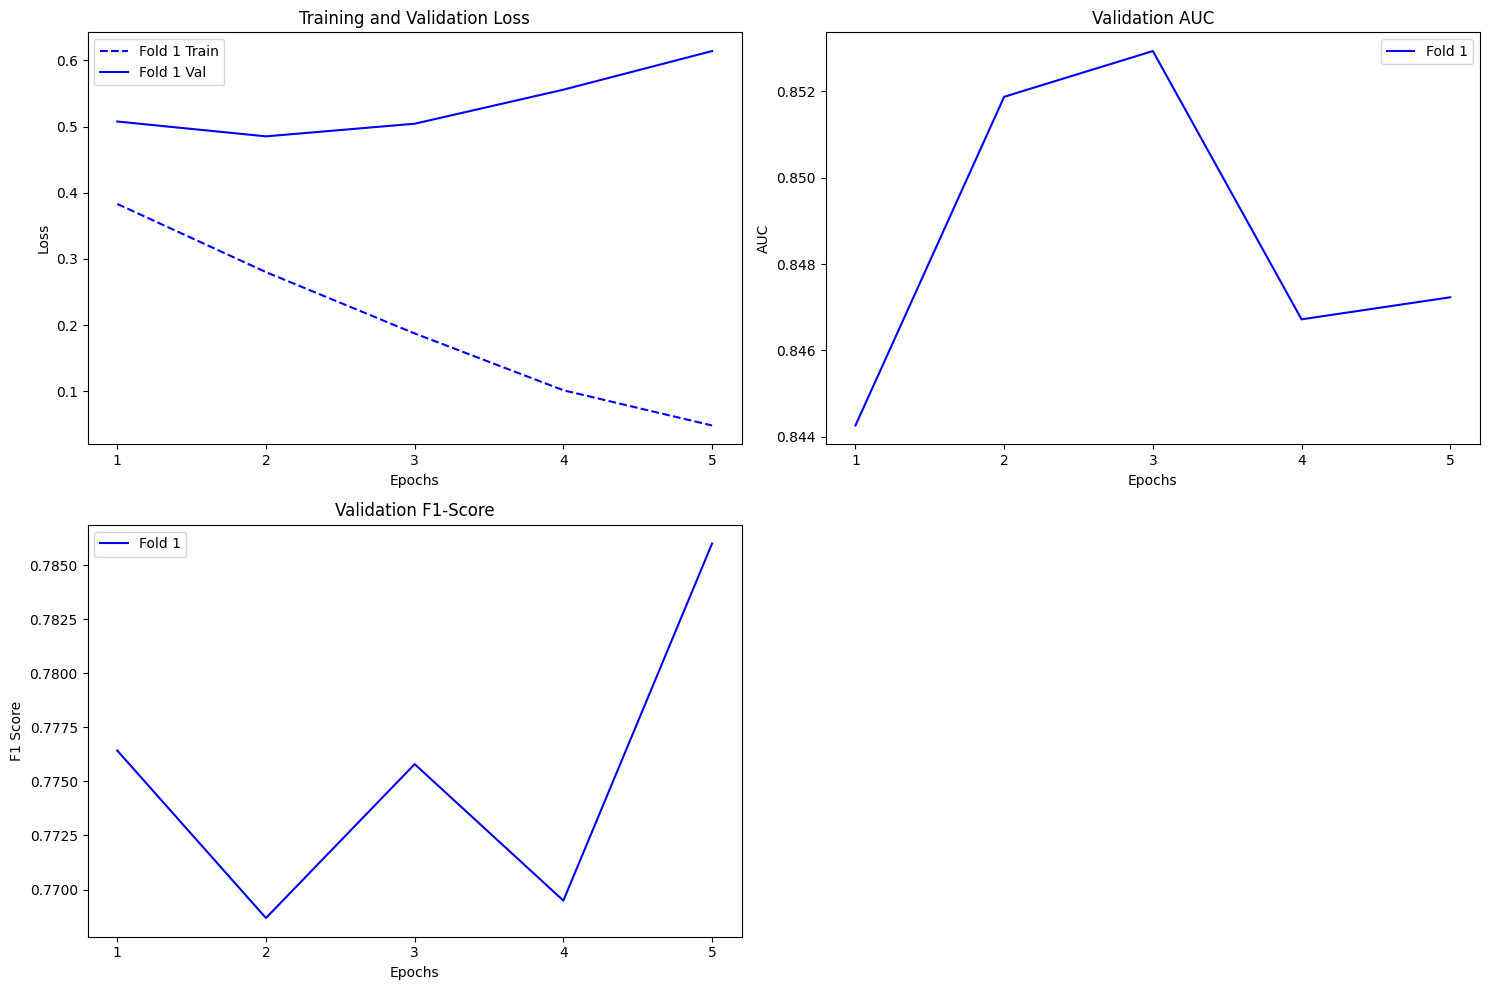

[codecarbon WARNING @ 20:51:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:51:14] [setup] RAM Tracking...
[codecarbon INFO @ 20:51:14] [setup] CPU Tracking...
[codecarbon WARNING @ 20:51:14] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 20:51:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:51:14] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 20:51:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:51:14] [setup] GPU Tracking...
[codecarbon INFO @ 20:51:14] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 20:51:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 2/5


[codecarbon INFO @ 20:52:24] Energy consumed for RAM : 0.021052 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:52:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:24] Energy consumed for All CPU : 0.023552 kWh
[codecarbon INFO @ 20:52:24] Energy consumed for all GPUs : 0.006399 kWh. Total GPU Power : 11.554045577552861 W
[codecarbon INFO @ 20:52:24] 0.051004 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:52:39] Energy consumed for RAM : 0.021210 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:52:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:39] Energy consumed for All CPU : 0.023729 kWh
[codecarbon INFO @ 20:52:39] Energy consumed for all GPUs : 0.006449 kWh. Total GPU Power : 11.976034881852014 W
[codecarbon INFO @ 20:52:39] 0.051389 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:

Fold 2, Epoch 1/100
Train Loss: 0.3828 | Val Loss: 0.5079
Val AUC: 0.8383, F1: 0.7564


[codecarbon INFO @ 20:58:09] Energy consumed for RAM : 0.024693 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:58:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:09] Energy consumed for All CPU : 0.027626 kWh
[codecarbon INFO @ 20:58:09] Energy consumed for all GPUs : 0.007555 kWh. Total GPU Power : 11.93221458597477 W
[codecarbon INFO @ 20:58:09] 0.059874 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:58:24] Energy consumed for RAM : 0.024851 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 20:58:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:24] Energy consumed for All CPU : 0.027803 kWh
[codecarbon INFO @ 20:58:24] Energy consumed for all GPUs : 0.007605 kWh. Total GPU Power : 12.040285849861274 W
[codecarbon INFO @ 20:58:24] 0.060259 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 20:5

Fold 2, Epoch 2/100
Train Loss: 0.2713 | Val Loss: 0.4822
Val AUC: 0.8568, F1: 0.7592


[codecarbon INFO @ 21:04:10] Energy consumed for RAM : 0.028491 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:04:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:10] Energy consumed for All CPU : 0.031876 kWh
[codecarbon INFO @ 21:04:10] Energy consumed for all GPUs : 0.008759 kWh. Total GPU Power : 11.950621904071133 W
[codecarbon INFO @ 21:04:10] 0.069126 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:04:25] Energy consumed for RAM : 0.028650 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:04:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:04:25] Energy consumed for All CPU : 0.032053 kWh
[codecarbon INFO @ 21:04:25] Energy consumed for all GPUs : 0.008809 kWh. Total GPU Power : 12.158866200786315 W
[codecarbon INFO @ 21:04:25] 0.069512 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:

Fold 2, Epoch 3/100
Train Loss: 0.1639 | Val Loss: 0.5025
Val AUC: 0.8523, F1: 0.7652


[codecarbon INFO @ 21:10:25] Energy consumed for RAM : 0.032449 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:10:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:25] Energy consumed for All CPU : 0.036303 kWh
[codecarbon INFO @ 21:10:25] Energy consumed for all GPUs : 0.010021 kWh. Total GPU Power : 12.095481892041757 W
[codecarbon INFO @ 21:10:25] 0.078773 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:10:40] Energy consumed for RAM : 0.032607 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:10:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:40] Energy consumed for All CPU : 0.036480 kWh
[codecarbon INFO @ 21:10:40] Energy consumed for all GPUs : 0.010071 kWh. Total GPU Power : 11.960867073569542 W
[codecarbon INFO @ 21:10:40] 0.079158 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:

Fold 2, Epoch 4/100
Train Loss: 0.0763 | Val Loss: 0.5864
Val AUC: 0.8390, F1: 0.7599


[codecarbon INFO @ 21:17:10] Energy consumed for RAM : 0.036723 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:17:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:10] Energy consumed for All CPU : 0.041085 kWh
[codecarbon INFO @ 21:17:10] Energy consumed for all GPUs : 0.011369 kWh. Total GPU Power : 12.136569658957592 W
[codecarbon INFO @ 21:17:10] 0.089176 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:17:10] 0.002524 g.CO2eq/s mean an estimation of 79.60946903299312 kg.CO2eq/year
[codecarbon INFO @ 21:17:25] Energy consumed for RAM : 0.036881 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:17:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:25] Energy consumed for All CPU : 0.041261 kWh
[codecarbon INFO @ 21:17:25] Energy consumed for all GPUs : 0.011440 kWh. Total GPU Power : 16.94328166489036 W
[codecarbon INFO @ 21:17:25] 0.08

Fold 2, Epoch 5/100
Train Loss: 0.0366 | Val Loss: 0.6228
Val AUC: 0.8429, F1: 0.7621
Early stopping at epoch 5


[codecarbon INFO @ 21:24:25] Energy consumed for all GPUs : 0.012699 kWh. Total GPU Power : 10.742813028758103 W
[codecarbon INFO @ 21:24:25] 0.100232 kWh of electricity and 0.000000 L of water were used since the beginning.


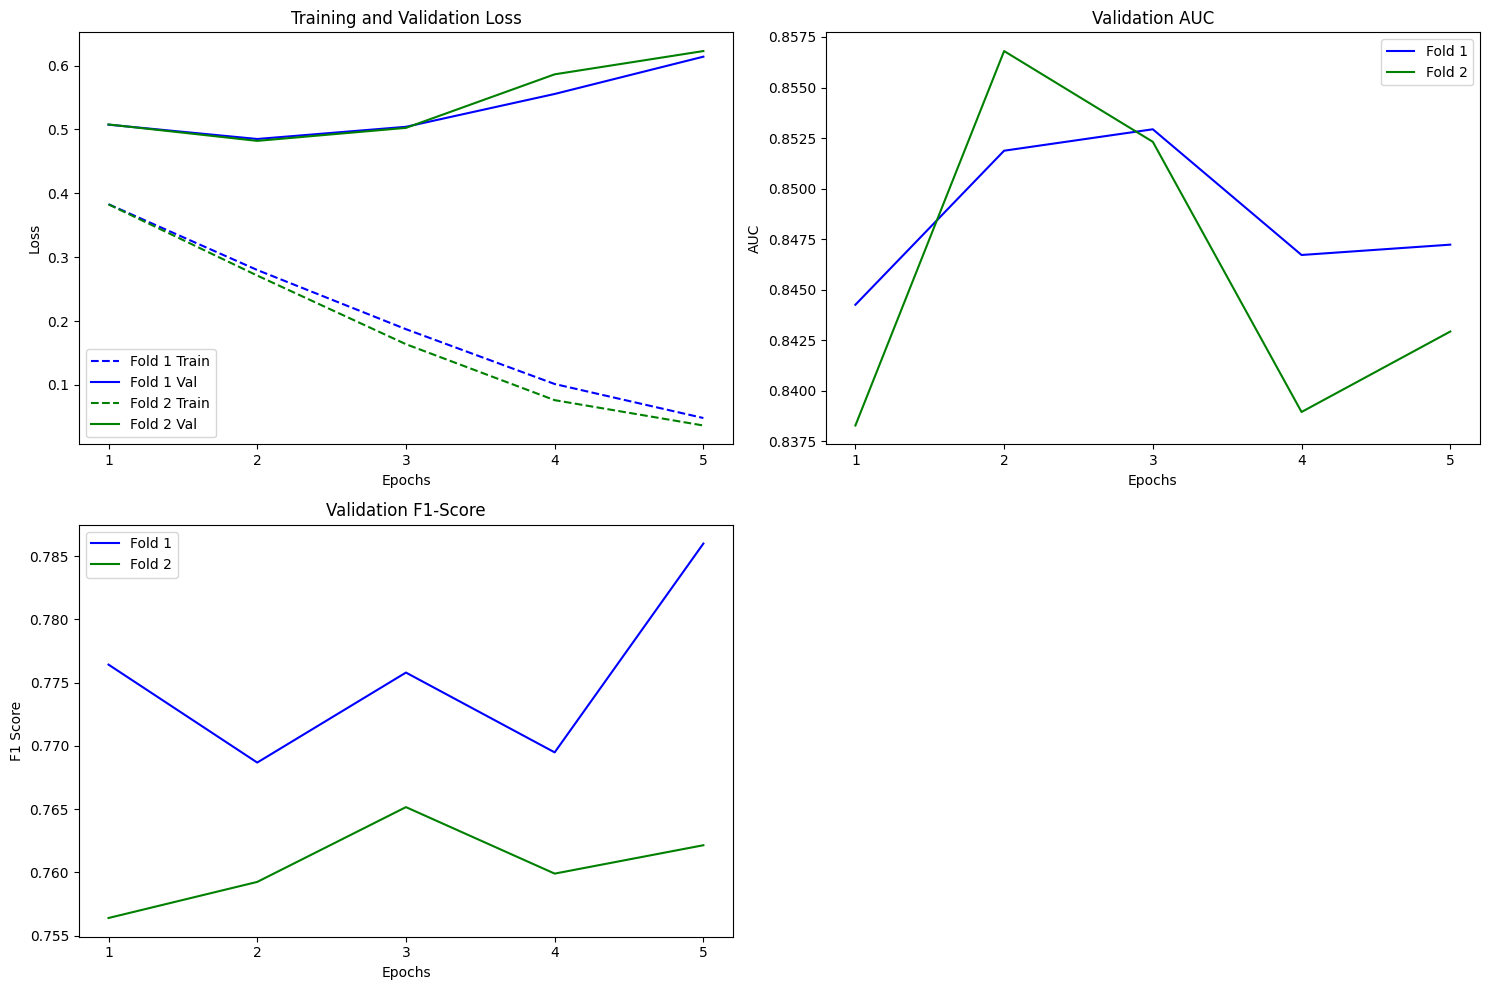

[codecarbon WARNING @ 21:24:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:24:26] [setup] RAM Tracking...
[codecarbon INFO @ 21:24:26] [setup] CPU Tracking...
[codecarbon WARNING @ 21:24:26] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:24:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:24:26] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 21:24:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:24:26] [setup] GPU Tracking...
[codecarbon INFO @ 21:24:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:24:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 3/5


[codecarbon INFO @ 21:25:40] Energy consumed for RAM : 0.042104 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:25:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:25:40] Energy consumed for All CPU : 0.047105 kWh
[codecarbon INFO @ 21:25:40] Energy consumed for all GPUs : 0.012927 kWh. Total GPU Power : 10.82262325238653 W
[codecarbon INFO @ 21:25:40] 0.102136 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:25:55] Energy consumed for RAM : 0.042262 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:25:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:25:55] Energy consumed for All CPU : 0.047282 kWh
[codecarbon INFO @ 21:25:55] Energy consumed for all GPUs : 0.012973 kWh. Total GPU Power : 11.035972164260203 W
[codecarbon INFO @ 21:25:55] 0.102518 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:2

Fold 3, Epoch 1/100
Train Loss: 0.3860 | Val Loss: 0.5306
Val AUC: 0.8180, F1: 0.7465


[codecarbon INFO @ 21:31:41] Energy consumed for RAM : 0.045903 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:31:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:31:41] Energy consumed for All CPU : 0.051355 kWh
[codecarbon INFO @ 21:31:41] Energy consumed for all GPUs : 0.014036 kWh. Total GPU Power : 11.229484032706544 W
[codecarbon INFO @ 21:31:41] 0.111294 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:31:56] Energy consumed for RAM : 0.046061 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:31:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:31:56] Energy consumed for All CPU : 0.051532 kWh
[codecarbon INFO @ 21:31:56] Energy consumed for all GPUs : 0.014083 kWh. Total GPU Power : 11.270131937368287 W
[codecarbon INFO @ 21:31:56] 0.111676 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:

Fold 3, Epoch 2/100
Train Loss: 0.2773 | Val Loss: 0.4969
Val AUC: 0.8389, F1: 0.7407


[codecarbon INFO @ 21:37:41] Energy consumed for RAM : 0.049702 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:37:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:37:41] Energy consumed for All CPU : 0.055605 kWh
[codecarbon INFO @ 21:37:41] Energy consumed for all GPUs : 0.015262 kWh. Total GPU Power : 11.77146778995875 W
[codecarbon INFO @ 21:37:41] 0.120569 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:37:56] Energy consumed for RAM : 0.049860 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:37:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:37:56] Energy consumed for All CPU : 0.055782 kWh
[codecarbon INFO @ 21:37:56] Energy consumed for all GPUs : 0.015312 kWh. Total GPU Power : 11.959641664695898 W
[codecarbon INFO @ 21:37:56] 0.120954 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:3

Fold 3, Epoch 3/100
Train Loss: 0.1936 | Val Loss: 0.4975
Val AUC: 0.8461, F1: 0.7582


[codecarbon INFO @ 21:44:11] Energy consumed for RAM : 0.053817 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:44:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:44:11] Energy consumed for All CPU : 0.060209 kWh
[codecarbon INFO @ 21:44:11] Energy consumed for all GPUs : 0.016561 kWh. Total GPU Power : 12.111127259016072 W
[codecarbon INFO @ 21:44:11] 0.130588 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:44:26] Energy consumed for RAM : 0.053976 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:44:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:44:26] Energy consumed for All CPU : 0.060386 kWh
[codecarbon INFO @ 21:44:26] Energy consumed for all GPUs : 0.016612 kWh. Total GPU Power : 12.150130795034034 W
[codecarbon INFO @ 21:44:26] 0.130973 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:

Fold 3, Epoch 4/100
Train Loss: 0.0997 | Val Loss: 0.5363
Val AUC: 0.8429, F1: 0.7625


[codecarbon INFO @ 21:51:11] Energy consumed for RAM : 0.058249 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:51:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:11] Energy consumed for All CPU : 0.065167 kWh
[codecarbon INFO @ 21:51:11] Energy consumed for all GPUs : 0.017967 kWh. Total GPU Power : 11.841730696466762 W
[codecarbon INFO @ 21:51:11] 0.141383 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:51:11] 0.002524 g.CO2eq/s mean an estimation of 79.60776459769613 kg.CO2eq/year
[codecarbon INFO @ 21:51:26] Energy consumed for RAM : 0.058407 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:51:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:51:26] Energy consumed for All CPU : 0.065344 kWh
[codecarbon INFO @ 21:51:26] Energy consumed for all GPUs : 0.018016 kWh. Total GPU Power : 11.92343853512135 W
[codecarbon INFO @ 21:51:26] 0.14

Fold 3, Epoch 5/100
Train Loss: 0.0535 | Val Loss: 0.5765
Val AUC: 0.8465, F1: 0.7702
Early stopping at epoch 5


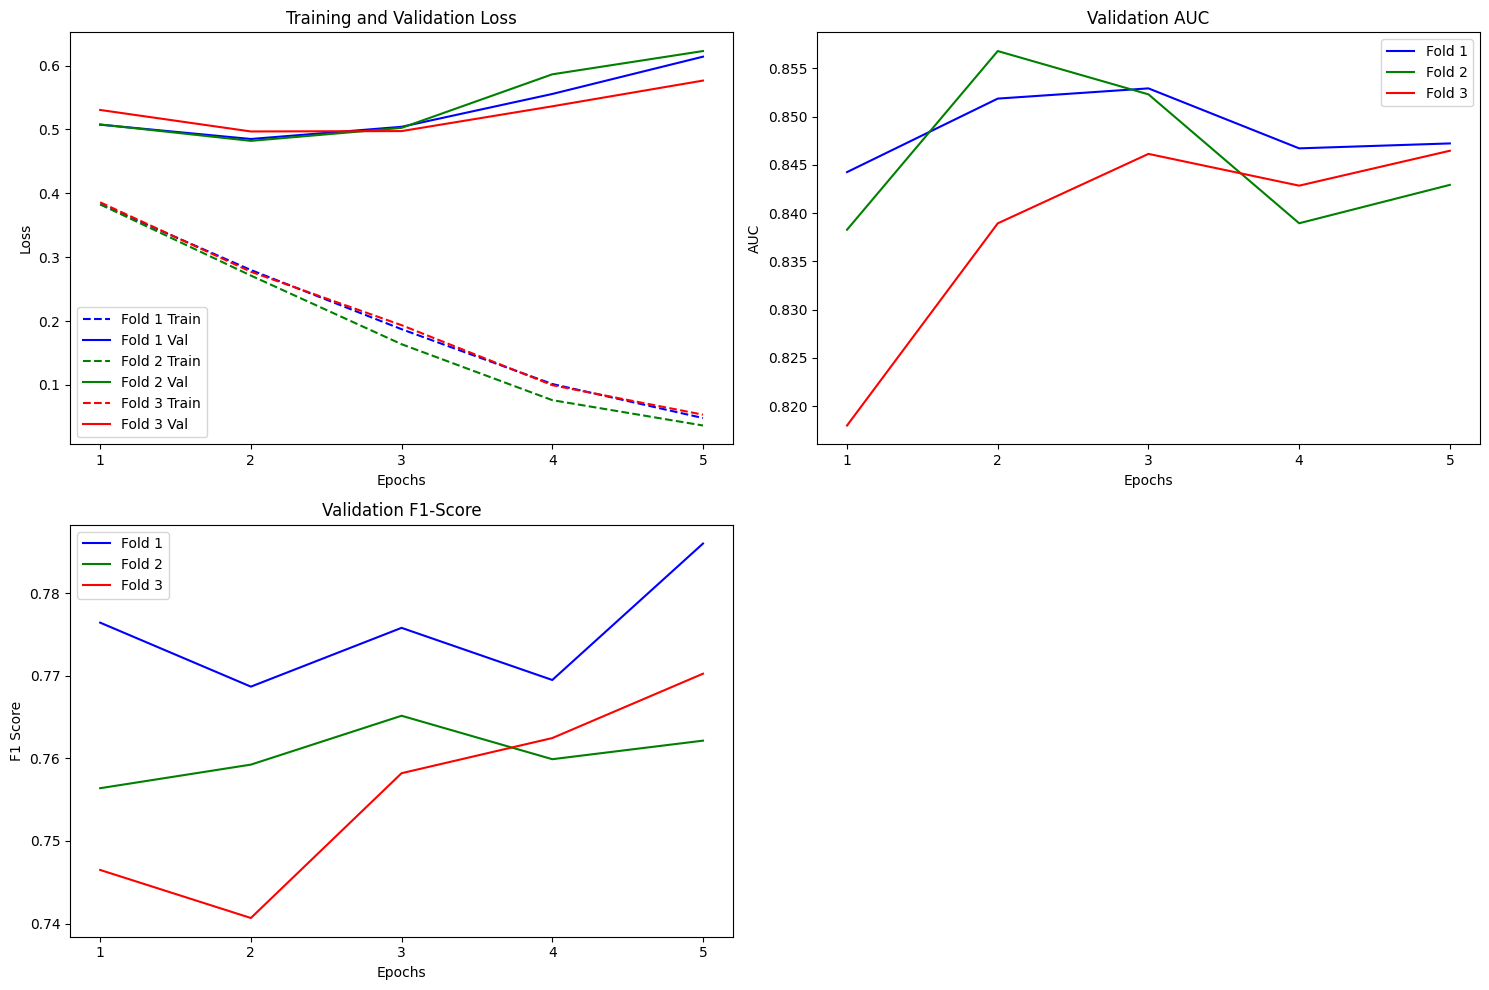

[codecarbon WARNING @ 21:58:20] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:58:20] [setup] RAM Tracking...
[codecarbon INFO @ 21:58:20] [setup] CPU Tracking...
[codecarbon WARNING @ 21:58:20] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 21:58:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 21:58:20] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 21:58:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:58:20] [setup] GPU Tracking...
[codecarbon INFO @ 21:58:20] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:58:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 4/5


[codecarbon INFO @ 21:59:26] Energy consumed for RAM : 0.063472 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:59:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:26] Energy consumed for All CPU : 0.071011 kWh
[codecarbon INFO @ 21:59:26] Energy consumed for all GPUs : 0.019593 kWh. Total GPU Power : 11.77806397351878 W
[codecarbon INFO @ 21:59:26] 0.154076 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:59:41] Energy consumed for RAM : 0.063630 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 21:59:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:59:41] Energy consumed for All CPU : 0.071188 kWh
[codecarbon INFO @ 21:59:41] Energy consumed for all GPUs : 0.019642 kWh. Total GPU Power : 11.707440855096396 W
[codecarbon INFO @ 21:59:41] 0.154460 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 21:5

Fold 4, Epoch 1/100
Train Loss: 0.3873 | Val Loss: 0.5357
Val AUC: 0.8121, F1: 0.7267


[codecarbon INFO @ 22:05:27] Energy consumed for RAM : 0.067270 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:05:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:27] Energy consumed for All CPU : 0.075260 kWh
[codecarbon INFO @ 22:05:27] Energy consumed for all GPUs : 0.020785 kWh. Total GPU Power : 11.743680334324125 W
[codecarbon INFO @ 22:05:27] 0.163316 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:05:42] Energy consumed for RAM : 0.067429 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:05:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:05:42] Energy consumed for All CPU : 0.075438 kWh
[codecarbon INFO @ 22:05:42] Energy consumed for all GPUs : 0.020836 kWh. Total GPU Power : 12.10748161366108 W
[codecarbon INFO @ 22:05:42] 0.163702 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:0

Fold 4, Epoch 2/100
Train Loss: 0.2869 | Val Loss: 0.4745
Val AUC: 0.8549, F1: 0.7742


[codecarbon INFO @ 22:11:27] Energy consumed for RAM : 0.071069 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:11:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:11:27] Energy consumed for All CPU : 0.079511 kWh
[codecarbon INFO @ 22:11:27] Energy consumed for all GPUs : 0.021975 kWh. Total GPU Power : 11.63741874145035 W
[codecarbon INFO @ 22:11:27] 0.172555 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:11:42] Energy consumed for RAM : 0.071227 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:11:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:11:42] Energy consumed for All CPU : 0.079688 kWh
[codecarbon INFO @ 22:11:42] Energy consumed for all GPUs : 0.022024 kWh. Total GPU Power : 11.806459043162624 W
[codecarbon INFO @ 22:11:42] 0.172939 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:1

Fold 4, Epoch 3/100
Train Loss: 0.1830 | Val Loss: 0.5080
Val AUC: 0.8490, F1: 0.7750


[codecarbon INFO @ 22:17:57] Energy consumed for RAM : 0.075184 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:17:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:17:57] Energy consumed for All CPU : 0.084115 kWh
[codecarbon INFO @ 22:17:57] Energy consumed for all GPUs : 0.023257 kWh. Total GPU Power : 11.70508075095385 W
[codecarbon INFO @ 22:17:57] 0.182556 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:18:12] Energy consumed for RAM : 0.075343 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:18:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:18:12] Energy consumed for All CPU : 0.084292 kWh
[codecarbon INFO @ 22:18:12] Energy consumed for all GPUs : 0.023307 kWh. Total GPU Power : 11.965500753680741 W
[codecarbon INFO @ 22:18:12] 0.182941 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:1

Fold 4, Epoch 4/100
Train Loss: 0.0801 | Val Loss: 0.5873
Val AUC: 0.8320, F1: 0.7600


[codecarbon INFO @ 22:24:57] Energy consumed for RAM : 0.079616 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:24:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:24:57] Energy consumed for All CPU : 0.089073 kWh
[codecarbon INFO @ 22:24:57] Energy consumed for all GPUs : 0.024650 kWh. Total GPU Power : 11.756011706667902 W
[codecarbon INFO @ 22:24:57] 0.193339 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:25:12] Energy consumed for RAM : 0.079774 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:25:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:25:12] Energy consumed for All CPU : 0.089250 kWh
[codecarbon INFO @ 22:25:12] Energy consumed for all GPUs : 0.024699 kWh. Total GPU Power : 11.81209164425048 W
[codecarbon INFO @ 22:25:12] 0.193724 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:2

Fold 4, Epoch 5/100
Train Loss: 0.0394 | Val Loss: 0.6545
Val AUC: 0.8405, F1: 0.7776
Early stopping at epoch 5


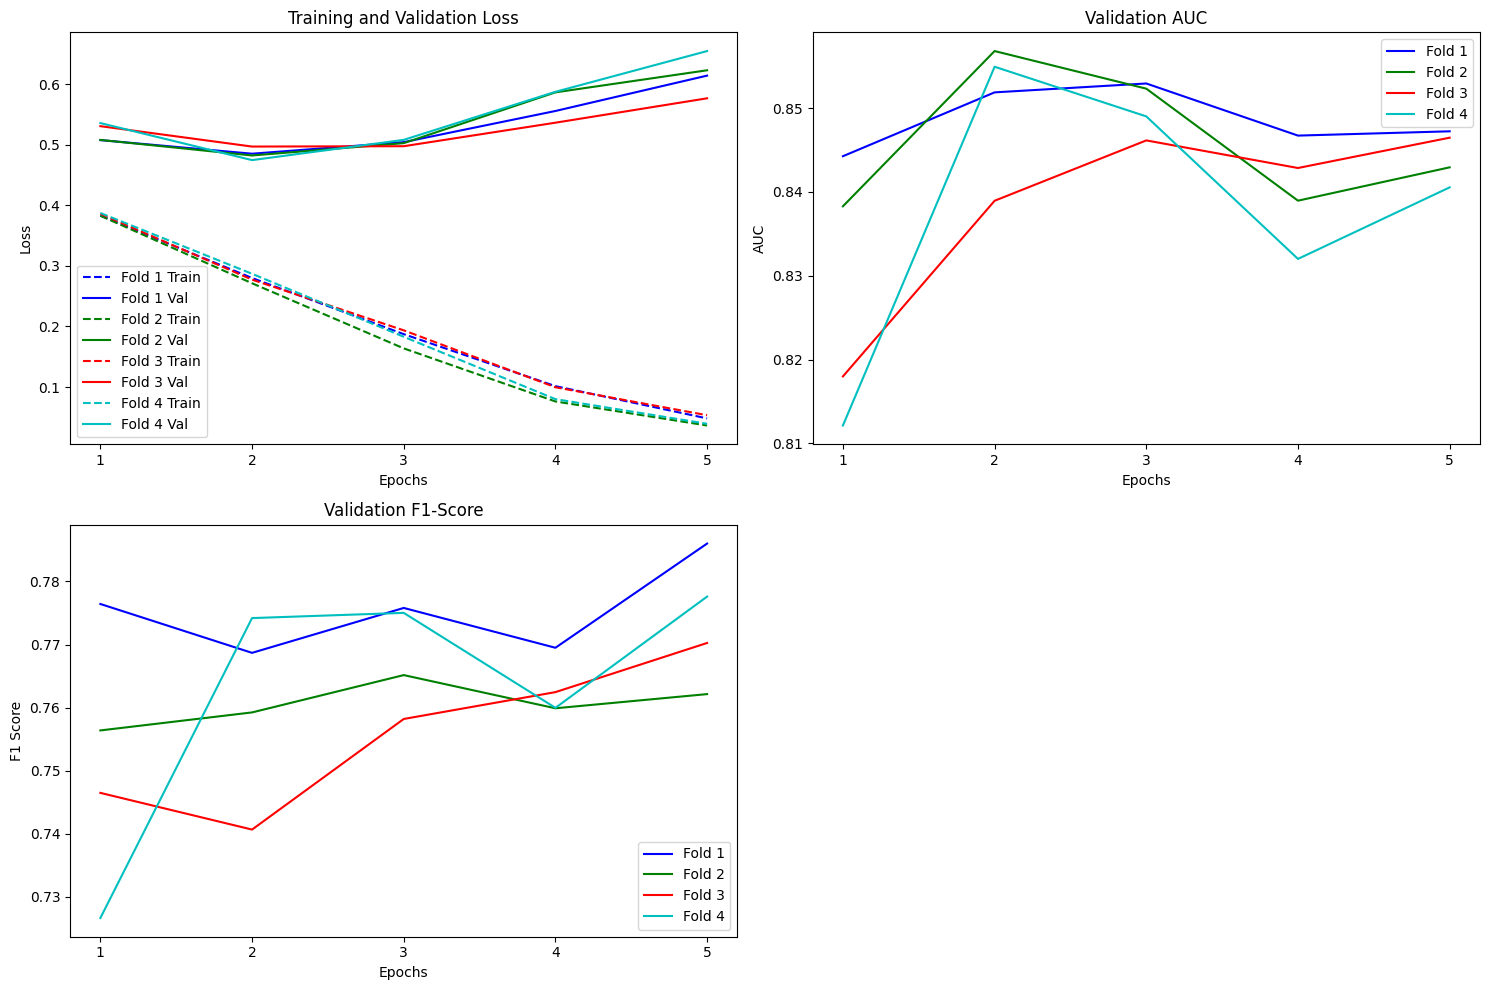

[codecarbon WARNING @ 22:32:04] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:32:04] [setup] RAM Tracking...
[codecarbon INFO @ 22:32:04] [setup] CPU Tracking...
[codecarbon WARNING @ 22:32:04] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 22:32:04] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:32:04] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 22:32:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:32:04] [setup] GPU Tracking...
[codecarbon INFO @ 22:32:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:32:04] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 5/5


[codecarbon INFO @ 22:33:13] Energy consumed for RAM : 0.084840 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:33:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:33:13] Energy consumed for All CPU : 0.094917 kWh
[codecarbon INFO @ 22:33:13] Energy consumed for all GPUs : 0.026274 kWh. Total GPU Power : 11.710901538477811 W
[codecarbon INFO @ 22:33:13] 0.206031 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:33:13] 0.002519 g.CO2eq/s mean an estimation of 79.43027129477582 kg.CO2eq/year
[codecarbon INFO @ 22:33:28] Energy consumed for RAM : 0.084998 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:33:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:33:28] Energy consumed for All CPU : 0.095094 kWh
[codecarbon INFO @ 22:33:28] Energy consumed for all GPUs : 0.026324 kWh. Total GPU Power : 12.01793174793427 W
[codecarbon INFO @ 22:33:28] 0.20

Fold 5, Epoch 1/100
Train Loss: 0.3697 | Val Loss: 0.5793
Val AUC: 0.7673, F1: 0.6819


[codecarbon INFO @ 22:39:13] Energy consumed for RAM : 0.088638 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:39:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:39:13] Energy consumed for All CPU : 0.099166 kWh
[codecarbon INFO @ 22:39:13] Energy consumed for all GPUs : 0.027465 kWh. Total GPU Power : 11.662311879757938 W
[codecarbon INFO @ 22:39:13] 0.215270 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:39:13] 0.002521 g.CO2eq/s mean an estimation of 79.50830237565773 kg.CO2eq/year
[codecarbon INFO @ 22:39:28] Energy consumed for RAM : 0.088796 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:39:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:39:28] Energy consumed for All CPU : 0.099344 kWh
[codecarbon INFO @ 22:39:28] Energy consumed for all GPUs : 0.027516 kWh. Total GPU Power : 12.141506689913319 W
[codecarbon INFO @ 22:39:28] 0.2

Fold 5, Epoch 2/100
Train Loss: 0.2678 | Val Loss: 0.5755
Val AUC: 0.7894, F1: 0.7086


[codecarbon INFO @ 22:45:28] Energy consumed for RAM : 0.092595 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:45:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:45:28] Energy consumed for All CPU : 0.103594 kWh
[codecarbon INFO @ 22:45:28] Energy consumed for all GPUs : 0.028707 kWh. Total GPU Power : 11.768303494416484 W
[codecarbon INFO @ 22:45:28] 0.224896 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:45:43] Energy consumed for RAM : 0.092754 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:45:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:45:43] Energy consumed for All CPU : 0.103771 kWh
[codecarbon INFO @ 22:45:43] Energy consumed for all GPUs : 0.028756 kWh. Total GPU Power : 11.807627551113258 W
[codecarbon INFO @ 22:45:43] 0.225280 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:

Fold 5, Epoch 3/100
Train Loss: 0.1765 | Val Loss: 0.6090
Val AUC: 0.7916, F1: 0.7205


[codecarbon INFO @ 22:51:58] Energy consumed for RAM : 0.096711 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:51:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:51:58] Energy consumed for All CPU : 0.108198 kWh
[codecarbon INFO @ 22:51:58] Energy consumed for all GPUs : 0.030005 kWh. Total GPU Power : 12.065057989231756 W
[codecarbon INFO @ 22:51:58] 0.234914 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:52:13] Energy consumed for RAM : 0.096869 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:52:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:52:13] Energy consumed for All CPU : 0.108375 kWh
[codecarbon INFO @ 22:52:13] Energy consumed for all GPUs : 0.030054 kWh. Total GPU Power : 11.83009703385614 W
[codecarbon INFO @ 22:52:13] 0.235299 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:5

Fold 5, Epoch 4/100
Train Loss: 0.0914 | Val Loss: 0.7489
Val AUC: 0.7827, F1: 0.6843


[codecarbon INFO @ 22:58:43] Energy consumed for RAM : 0.100985 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:58:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:58:43] Energy consumed for All CPU : 0.112980 kWh
[codecarbon INFO @ 22:58:43] Energy consumed for all GPUs : 0.031337 kWh. Total GPU Power : 11.833288992121519 W
[codecarbon INFO @ 22:58:43] 0.245303 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:58:58] Energy consumed for RAM : 0.101144 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 22:58:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:58:58] Energy consumed for All CPU : 0.113157 kWh
[codecarbon INFO @ 22:58:58] Energy consumed for all GPUs : 0.031386 kWh. Total GPU Power : 11.732797940374285 W
[codecarbon INFO @ 22:58:58] 0.245687 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 22:

Fold 5, Epoch 5/100
Train Loss: 0.0462 | Val Loss: 0.7997
Val AUC: 0.7818, F1: 0.7052
Early stopping at epoch 5


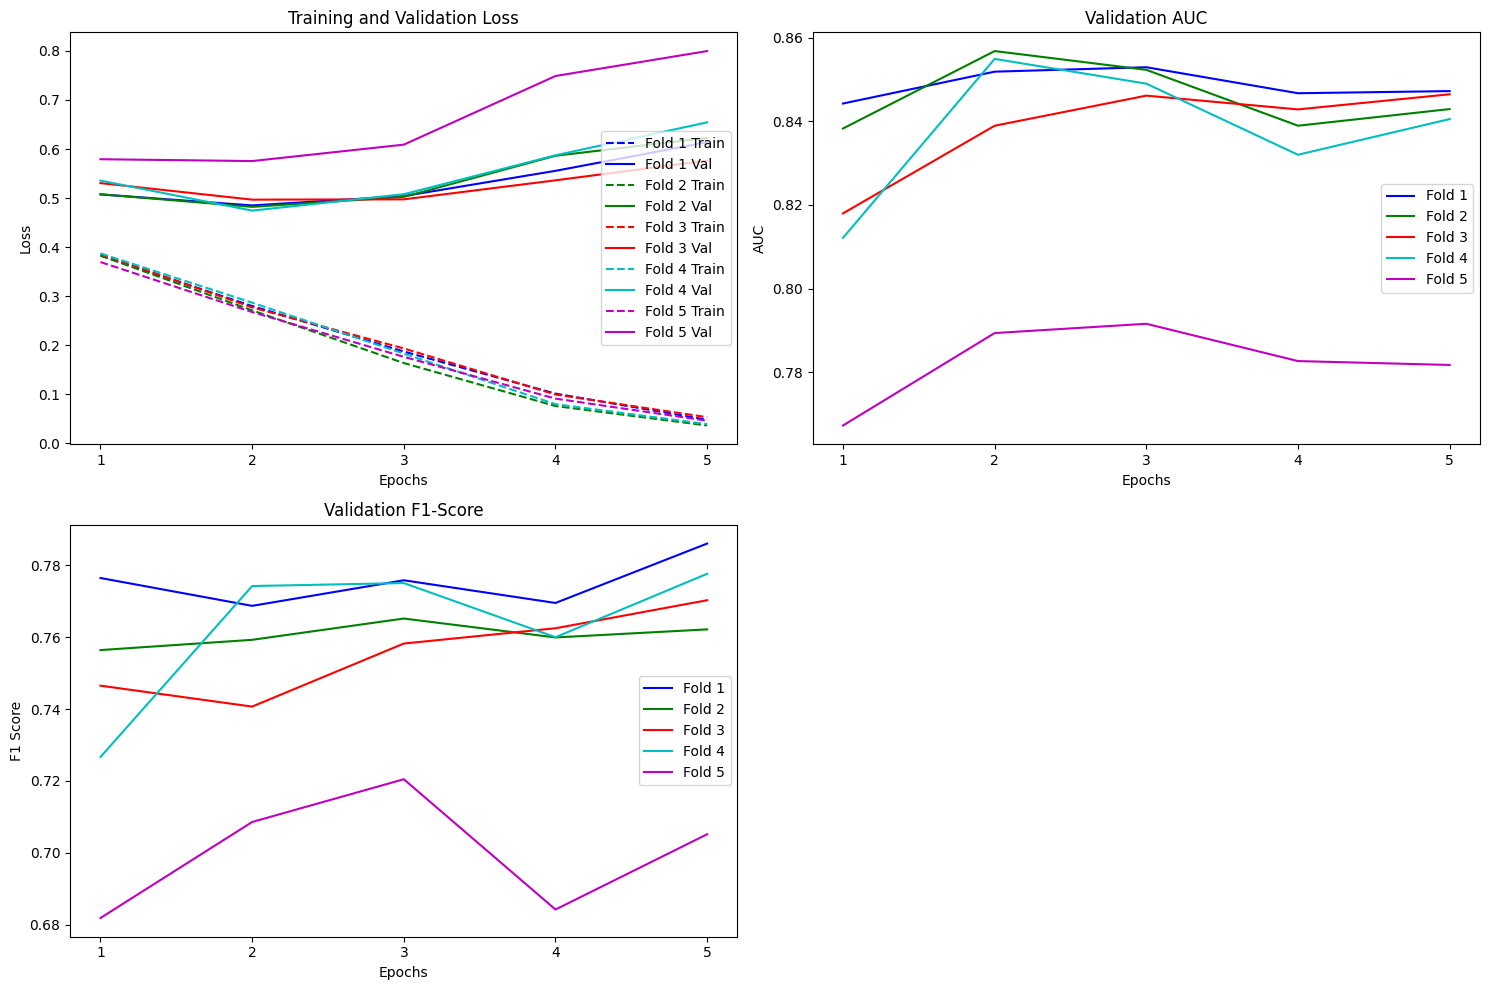

[codecarbon WARNING @ 23:06:00] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:06:00] [setup] RAM Tracking...
[codecarbon INFO @ 23:06:00] [setup] CPU Tracking...
[codecarbon WARNING @ 23:06:00] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 23:06:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 23:06:00] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 23:06:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:06:00] [setup] GPU Tracking...
[codecarbon INFO @ 23:06:00] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:06:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Resultados da Validação Cruzada:

--- Métricas de Validação ---
Val_AUC: 0.8384 ± 0.0253
Val_PR_AUC: 0.8402 ± 0.0264
Val_F1: 0.7503 ± 0.0238
Val_ACCURACY: 0.7599 ± 0.0217
Val_PRECISION: 0.7818 ± 0.0262
Val_RECALL: 0.7219 ± 0.0319

--- Métricas de Teste Interno ---
Test_AUC: 0.8841 ± 0.0091
Test_PR_AUC: 0.8912 ± 0.0104
Test_F1: 0.7939 ± 0.0059
Test_ACCURACY: 0.8032 ± 0.0047
Test_PRECISION: 0.8338 ± 0.0155
Test_RECALL: 0.7583 ± 0.0188
CPU times: total: 2d 15h 36min 21s
Wall time: 2h 48min 2s


In [12]:
%%time
# Executar
if __name__ == "__main__":
    fold_histories, all_metrics = cross_validation()

    # Exemplo Grad-CAM
    # model = create_model().eval()
    # sample_img, _ = dataset[0]
    # target_layer = model.layer4[-1] if MODEL_NAME == "resnet50" else model.features[-1]
    # cam_image = generate_grad_cam(model, sample_img.to(DEVICE), target_layer)
    #
    # plt.imshow(cam_image)
    # plt.title('Grad-CAM Visualization')
    # plt.axis('off')
    # plt.show()